<a href="https://colab.research.google.com/github/StephaneWamba/Machine-Learning-Finance/blob/main/Prediction_du_risque_de_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prédiction de Risque de Crédit**
Ce projet vise à développer un modèle de prédiction de risque de crédit en utilisant diverses techniques. L'objectif principal est de créer un outil de décision évaluant le risque associé à l'octroi de prêts, en se basant sur des caractéristiques financières et personnelles.

Nous suivrons une méthodologie comprenant l'exploration des données, le prétraitement, la modélisation, et l'évaluation des performances. En raison des limitations en ressources computationnelles, nous ne pourrons pas affiner très librement nos modèles comme on nous le souhaiterions. Toutefois, nous essaierons d'atteindre une précision supérieure à 90%.

Le dataset utilisé est destiné à la prédiction du risque de crédit, crucial dans le domaine financier. Il comprend diverses données telles que l'âge, le revenu, la durée de l'emploi, le montant du prêt, etc. Téléchargé depuis Kaggle, cette plateforme offre des ressources riches pour la science des données.

Lien vers le dataset : [Credit Risk Dataset on Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data).

In [1]:
#On importe toutes les bibliotheques qui nous serviront par la suite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Exploration des données

In [2]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Analyse du rsique de Credit/credit_risk_dataset.csv"
df = pd.read_csv(dataset_path)

In [3]:
# Affichage des premières lignes du dataset
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# Informations sur les types de données et les valeurs manquantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
# Statistiques descriptives
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [6]:
#Valeurs manquantes
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

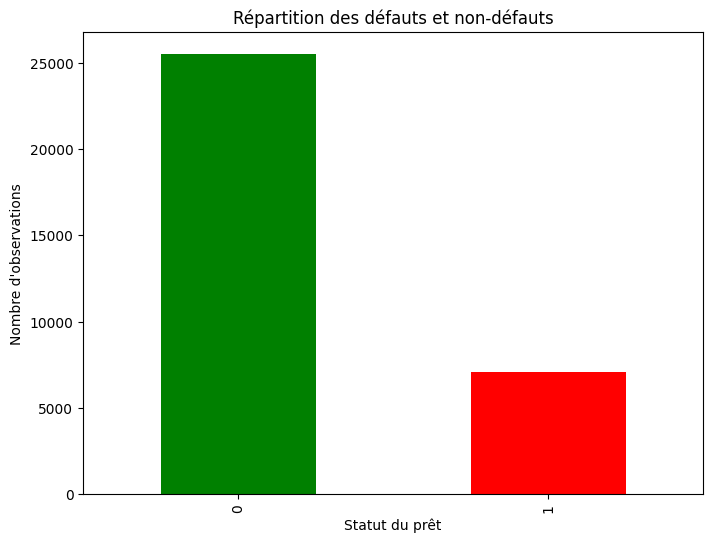

In [7]:
# Visualisation de la répartition des défauts et non-défauts
plt.figure(figsize=(8, 6))
df['loan_status'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Répartition des défauts et non-défauts')
plt.xlabel('Statut du prêt')
plt.ylabel('Nombre d\'observations')
plt.show()

Le statut du prêt est très déséquilibré entre les classes 0 et 1. Dans la suite, nous suréchantillonnerons la classe minoritaire.

Rapport de Classification (Random Forest):
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5072
           1       0.96      0.71      0.82      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.85      0.89      6517
weighted avg       0.93      0.93      0.93      6517

Rapport de Classification (Logistic Regression):
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      5072
           1       0.71      0.15      0.25      1445

    accuracy                           0.80      6517
   macro avg       0.76      0.57      0.57      6517
weighted avg       0.78      0.80      0.74      6517

Rapport de Classification (Support Vector Machine):
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      5072
           1       0.82      0.15      0.25      1445

    accuracy                          

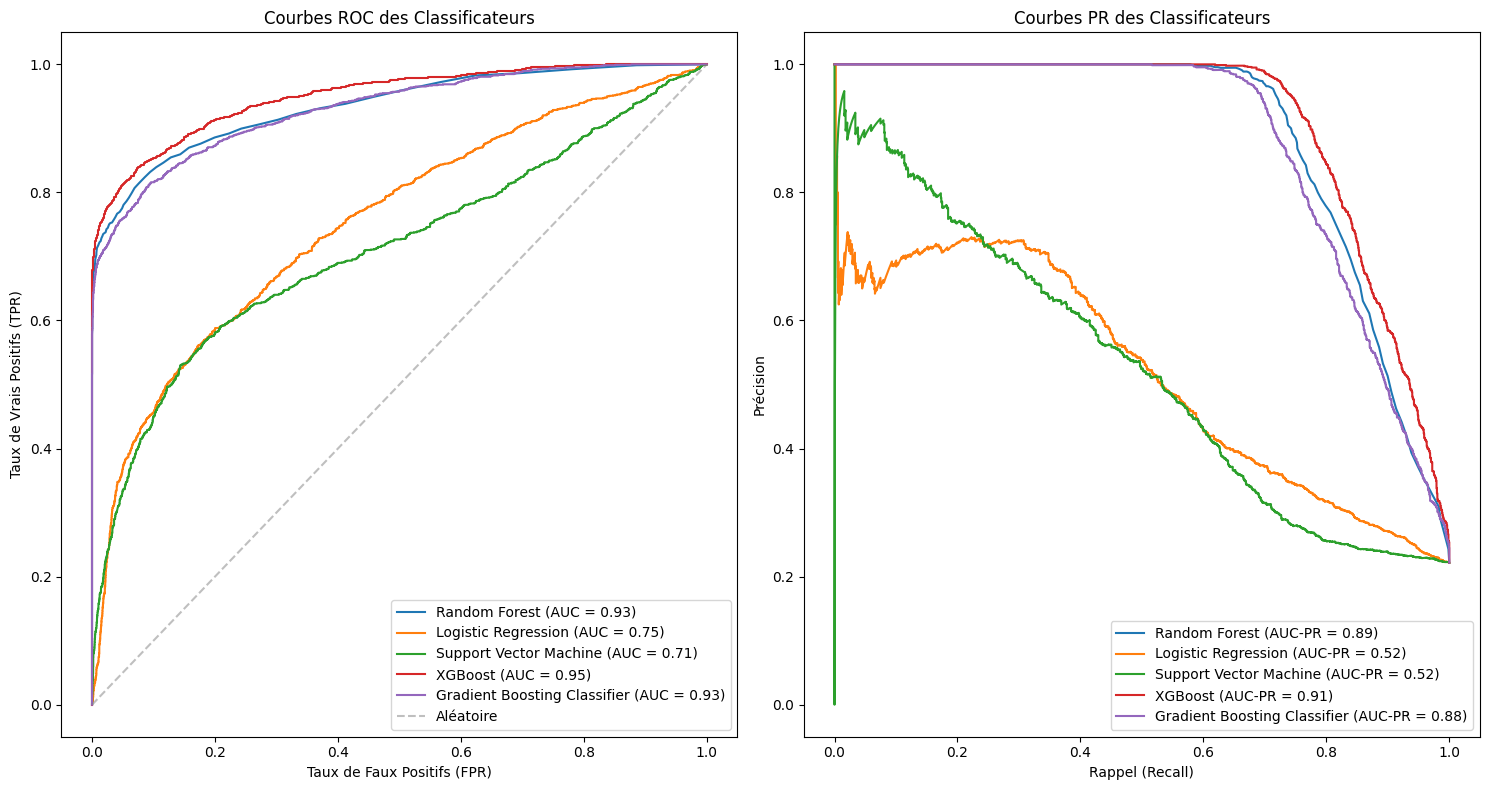

Rapport de Classification (Voting Classifier):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5072
           1       0.98      0.67      0.80      1445

    accuracy                           0.92      6517
   macro avg       0.95      0.84      0.88      6517
weighted avg       0.93      0.92      0.92      6517

ROC-AUC (Voting Classifier):  0.9302551220896598
PR-AUC (Voting Classifier):  0.8847329066304999


In [8]:
### Prétraitement les données

#Remplace les valeurs manquantes, en l'occurrence numériques par les médianes.
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

#Encode numeriquement les variables catégorielles pour une meilleure performance des modèles d'entrainement
label_encoder = LabelEncoder()
df['person_home_ownership'] = label_encoder.fit_transform(df['person_home_ownership'])
df['loan_intent'] = label_encoder.fit_transform(df['loan_intent'])
df['loan_grade'] = label_encoder.fit_transform(df['loan_grade'])
df['cb_person_default_on_file'] = label_encoder.fit_transform(df['cb_person_default_on_file'])

# Divise les données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['loan_status']), df['loan_status'], test_size=0.2, random_state=42)

#On corrige les desequilibres dans les donnees.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialise les classificateurs
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}

# Entraînement et évaluation des classificateurs individuels
plt.figure(figsize=(15, 8))
for name, clf in classifiers.items():
    # Entraînement du modèle
    clf.fit(X_train, y_train)

    # Prédictions de probabilité
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Calcul des faux positifs, vrais positifs et seuils pour ROC
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)

    # Calcul de l'aire sous la courbe ROC (ROC-AUC)
    roc_auc = auc(fpr, tpr)

    # Calcul des précisions, rappels et seuils pour PR
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

    # Calcul de l'aire sous la courbe PR (AUC-PR)
    pr_auc = average_precision_score(y_test, y_prob)

    # Affichage de la courbe ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Affichage de la courbe PR
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{name} (AUC-PR = {pr_auc:.2f})')

    # Rapport de Classification
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"Rapport de Classification ({name}):\n{report}")

# Affichage des courbes ROC (Receiver Operating Characteristic)
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aléatoire', alpha=0.5)
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC des Classificateurs')
plt.legend()

# Affichage des courbes PR
plt.subplot(1, 2, 2)
plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision')
plt.title('Courbes PR des Classificateurs')
plt.legend()

# Affichage global
plt.tight_layout()
plt.show()

# Entraînement du classificateur par vote majoritaire
voting_classifier = VotingClassifier(estimators=list(classifiers.items()), voting='soft')
voting_classifier.fit(X_train, y_train)
y_pred = voting_classifier.predict(X_test)
print(f"Rapport de Classification (Voting Classifier):\n{classification_report(y_test, y_pred)}")
y_prob = voting_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("ROC-AUC (Voting Classifier): ", roc_auc)
pr_auc = average_precision_score(y_test, y_prob)
print("PR-AUC (Voting Classifier): ",  pr_auc)


**Courbe ROC (Receiver Operating Characteristic):**

Représente la relation entre le taux de vrais positifs (sensibilité) et le taux de faux positifs.
L'axe des x représente le taux de faux positifs, et l'axe des y représente le taux de vrais positifs.
Une courbe idéale se rapproche du coin supérieur gauche.
L'aire sous la courbe ROC (ROC-AUC) mesure la performance globale, avec 1 indiquant une performance parfaite.

**Courbe PR (Precision-Recall):**

Représente la relation entre la précision et le rappel pour différents seuils de classification.
L'axe des x représente le rappel, et l'axe des y représente la précision.
Une courbe idéale se rapproche du coin supérieur droit.
L'aire sous la courbe PR (AUC-PR) mesure la performance globale, avec 1 indiquant une performance parfaite.


**Remarques Générales :**

Les modèles semblent bien performants pour la classe 0 (non-défaut), mais présentent des défis dans la détection des défauts (classe 1).
XGBoost semble offrir de meilleures performances globales avec une précision, un rappel et une AUC-PR plus élevée.
Le classificateur par vote majoritaire pourrait améliorer la performance en combinant les forces de plusieurs modèles, mais il nécessite un ajustement fin des poids ou des stratégies de vote pour mieux gérer les modèles sous-performants.
Il serait judicieux d'explorer davantage les hyperparamètres, d'ajuster les poids dans le Voting Classifier, ou même d'essayer d'autres algorithmes pour améliorer les performances, en particulier pour la détection des défauts.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score, classification_report

# Chargement des données
file_path = "/content/drive/MyDrive/Colab Notebooks/Analyse du rsique de Credit/credit_risk_dataset.csv"
df = pd.read_csv(file_path)

# Prétraitement des données
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

# Séparation des features et de la cible
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encodage one-hot des variables catégoriques
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
                    'loan_percent_income', 'cb_person_cred_hist_length']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Définition des modèles
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
}

# Création du Voting Classifier
voting_classifier = VotingClassifier(estimators=list(models.items()), voting='soft')

# Pipeline pour le prétraitement et la modélisation
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', voting_classifier)])

# Score à optimiser (AUC-ROC)
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Recherche d'hyperparamètres avec GridSearchCV (simplifié)
param_grid = {
    'model__Random Forest__n_estimators': [50, 100],
    'model__XGBoost__n_estimators': [50, 100],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scorer, cv=3)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
best_params = grid_search.best_params_

# Entraînement du modèle avec les meilleurs paramètres
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Rapport de classification
print("Rapport de Classification (Voting Classifier):\n", classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC: ", roc_auc)

# AUC-PR
pr_auc = average_precision_score(y_test, y_prob)
print("AUC-PR: ", pr_auc)


Rapport de Classification (Voting Classifier):
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.96      0.73      0.83      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517

ROC-AUC:  0.9477589152194558
AUC-PR:  0.9048946473295124


Le classificateur par vote majoritaire amélioré montre une amélioration significative par rapport à sa version précédente, avec des scores équilibrés de précision et de rappel pour prédire les risques de crédit.

Aves des ajustements plus fins, on atteindrait de meilleures performances avec le classificateur par vote majoritaire.